In [1]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_test = pd.read_csv('2022_data_integrated.csv', index_col='Datetime', parse_dates=True)
df_training = pd.read_csv('training_data_integrated.csv')
df_test_daily = pd.read_csv('2022_daily_data_integrated.csv')
df_training_daily = pd.read_csv('training_daily_data_integrated.csv')
df_test_weekly = pd.read_csv('test_weekly_data_integrated.csv')
df_training_weekly = pd.read_csv('training_weekly_data_integrated.csv')
df_test_monthly = pd.read_csv('test_monthly_data_integrated.csv')
df_training_monthly = pd.read_csv('training_monthly_data_integrated.csv')

df_prophet = pd.read_csv('prophet_bonn_integrated.csv')
df_prophet_daily = pd.read_csv('prophet_daily_integrated.csv')

holidays = pd.read_csv('df_feiertage.csv')

In [2]:
def median_absolute_percentage_error(actual_values, predicted_values):
    
    mdape = np.median(np.abs(np.array(actual_values) - np.array(predicted_values)) / np.abs(np.array(actual_values))) * 100

    return mdape

In [3]:
df_test_temp = df_test.resample('D').mean()

df_prophet_daily = df_prophet_daily[['ds', 'y', 'temp']]
df_prophet_daily['temp'] = np.where((df_prophet_daily['temp'] < -10.0), np.nan, df_prophet_daily['temp'])
df_prophet_daily['temp'] = df_prophet_daily['temp'].fillna(method='ffill')
df_prophet_daily

,ds,y,temp
0,2016-01-01,5128.0,5.508333
1,2016-01-02,2908.0,3.837500
2,2016-01-03,5009.0,5.766667
3,2016-01-04,8727.0,4.995833
4,2016-01-05,11721.0,6.208333
...,...,...,...
2187,2021-12-27,9729.0,5.616667
2188,2021-12-28,7595.0,8.683333
2189,2021-12-29,9772.0,9.416667
2190,2021-12-30,11774.0,13.104167


19:58:00 - cmdstanpy - INFO - Chain [1] start processing
19:58:01 - cmdstanpy - INFO - Chain [1] done processing


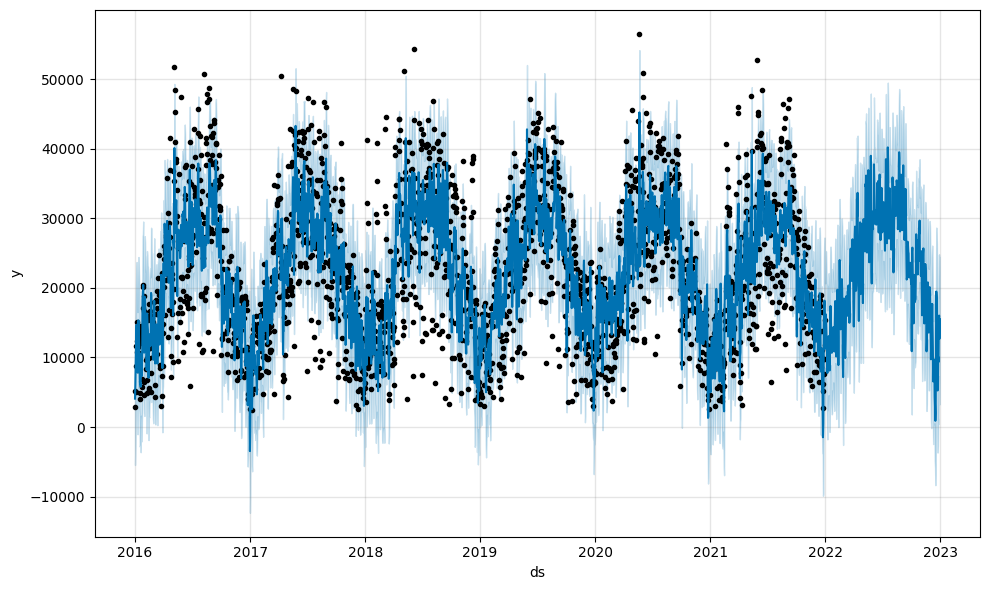

In [4]:
model = Prophet(holidays=holidays, changepoint_prior_scale=0.1, seasonality_prior_scale=1, scaling='minmax')
model.add_country_holidays(country_name='Germany')
model.add_regressor('temp')
model.fit(df_prophet_daily)
future = model.make_future_dataframe(periods=365, freq='D')
future['temp'] = pd.concat([df_prophet_daily['temp'], df_test_temp['Temperature (°C)']], ignore_index=True)

forecast = model.predict(future)
fig = model.plot(forecast)

<Figure size 1200x600 with 0 Axes>

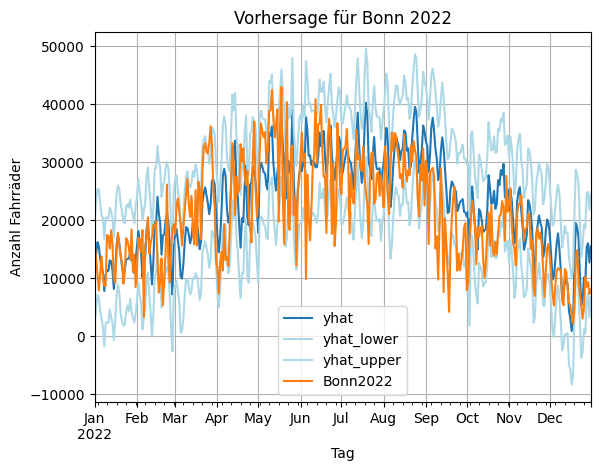

In [5]:
forecasted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecasted_values['yhat'] = np.where(forecasted_values['yhat'] < 0, 0, forecasted_values['yhat'])
forecasted_values['ds'] = pd.to_datetime(forecasted_values['ds'])

measured_values = df_test_daily[['Datetime', 'Bonn2022']].copy()
measured_values = measured_values.rename(columns={'Datetime': 'ds'})
measured_values['ds'] = pd.to_datetime(measured_values['ds'])

merged_data = pd.merge(forecasted_values, measured_values, on='ds', how='inner')
merged_data.set_index('ds', inplace=True)

plt.figure(figsize=(12,6))
merged_data.plot(color=['tab:blue', 'lightblue', 'lightblue', 'tab:orange'])
plt.title('Vorhersage für Bonn 2022')
plt.ylabel('Anzahl Fahrräder')
plt.xlabel('Tag')
plt.grid()
plt.show()

#mae_daily = mean_absolute_error(merged_data['Bonn2022'], merged_data['yhat'])
#mse_daily = mean_squared_error(merged_data['Bonn2022'], merged_data['yhat'])
#mdape_daily = median_absolute_percentage_error(merged_data['Bonn2022'], merged_data['yhat'])

#inside_interval = ((merged_data['Bonn2022'] >= merged_data['yhat_lower']) & (merged_data['Bonn2022'] <= merged_data['yhat_upper'])).sum()
#percent_inside_interval = (inside_interval / len(merged_data['Bonn2022'])) * 100

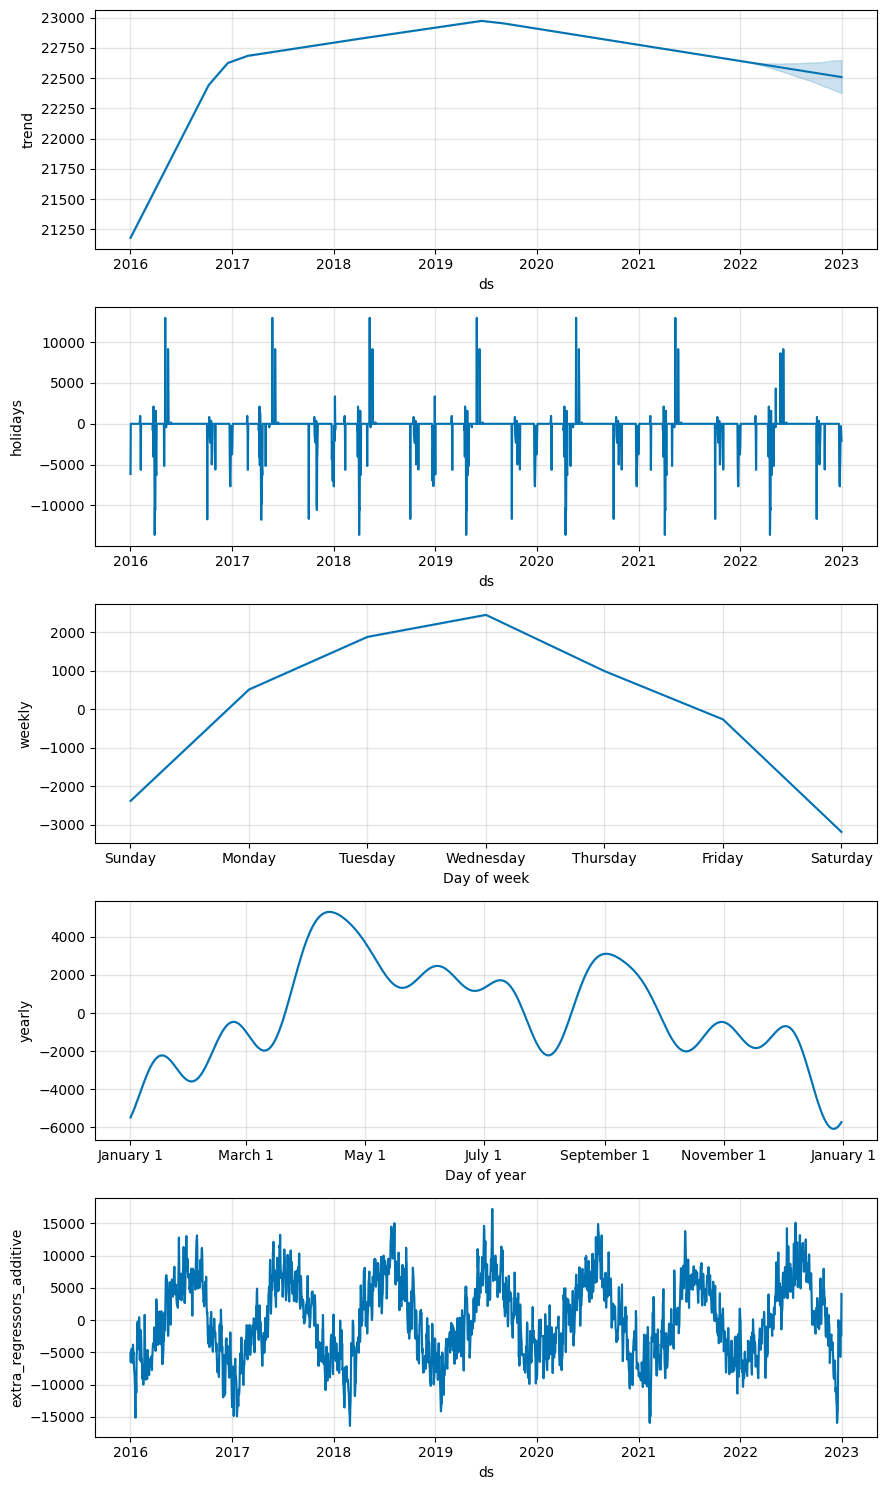

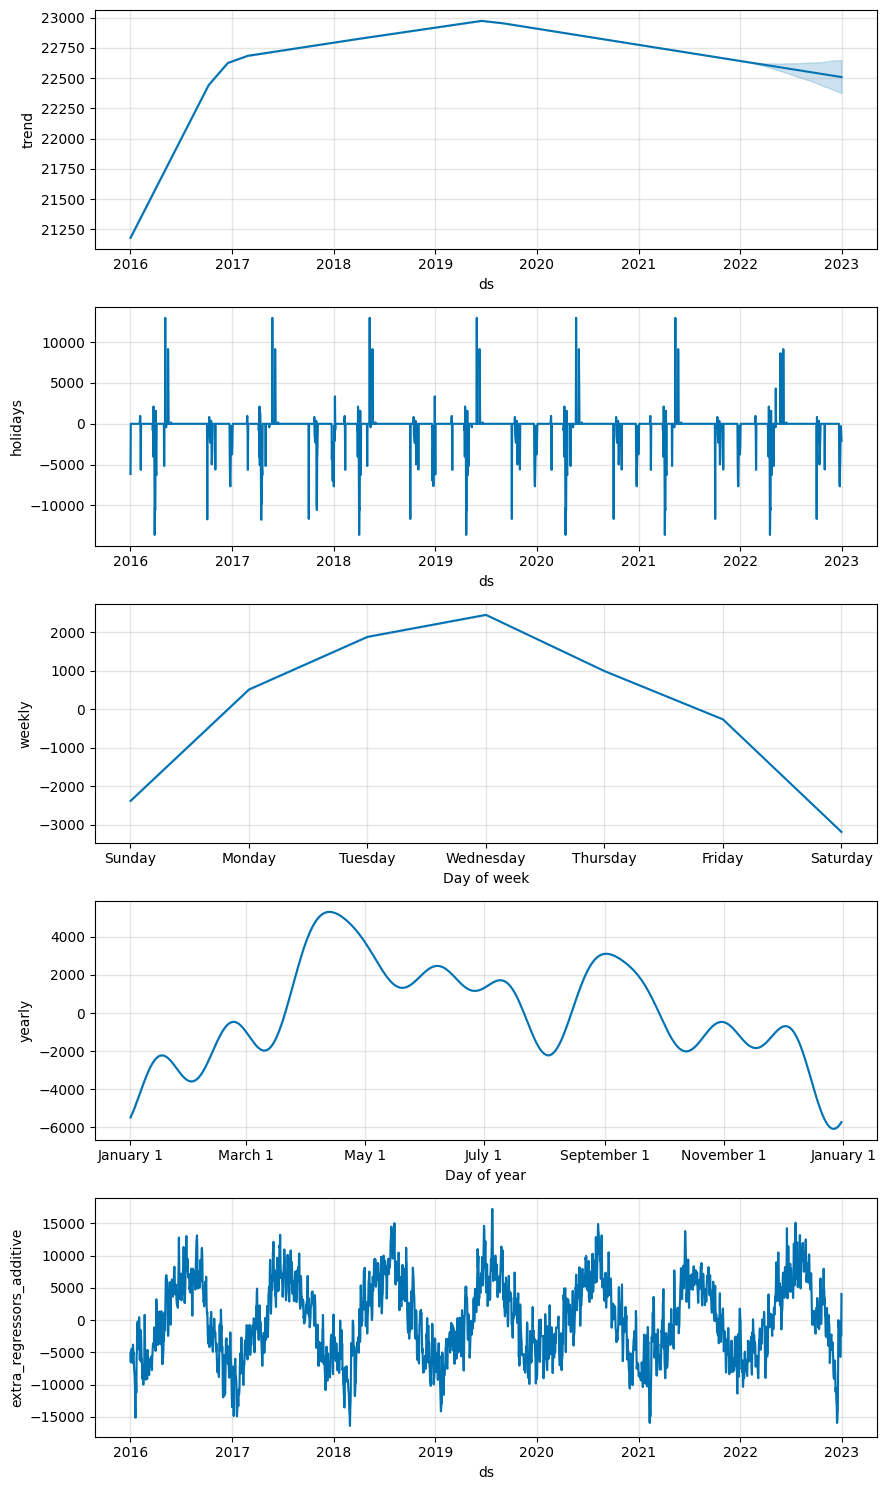

In [6]:
model.plot_components(forecast)

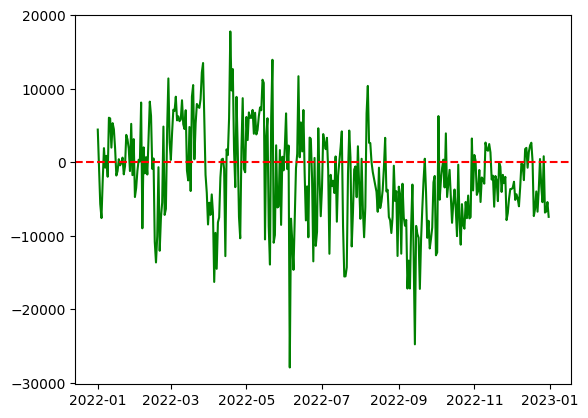

In [7]:
residuals = merged_data['Bonn2022'] - merged_data['yhat']
plt.plot(merged_data.index, residuals, label='Residuals', color='green')
plt.axhline(y=0, color='red', linestyle='--', label='Baseline at 0')

In [8]:
df_bonn_weekly = df_training_weekly[['Datetime', 'Bonn']]
df_bonn_weekly = df_bonn_weekly.rename(columns={'Datetime': 'ds', 'Bonn': 'y'})

df_temp_weekly = pd.read_csv('training_data_integrated.csv', index_col='Datetime', parse_dates=True)
df_temp_weekly = df_temp_weekly.resample('W').mean()
df_temp_weekly = df_temp_weekly.reset_index(drop=True)

df_bonn_weekly = pd.concat([df_bonn_weekly, df_temp_weekly['Temperature (°C)']], axis=1)
df_bonn_weekly = df_bonn_weekly.rename(columns={'Temperature (°C)': 'temp'})

df_bonn_weekly.to_csv('prophet_weekly_integrated.csv')
df_bonn_weekly

df_test_temp_weekly = df_test.resample('W').mean()

df_bonn_weekly['temp'] = np.where((df_bonn_weekly['temp'] < -10.0), np.nan, df_bonn_weekly['temp'])
df_bonn_weekly['temp'] = df_bonn_weekly['temp'].fillna(method='ffill')

In [9]:
(df_bonn_weekly['temp'] < -10.0).any()

False

19:58:41 - cmdstanpy - INFO - Chain [1] start processing
19:58:41 - cmdstanpy - INFO - Chain [1] done processing


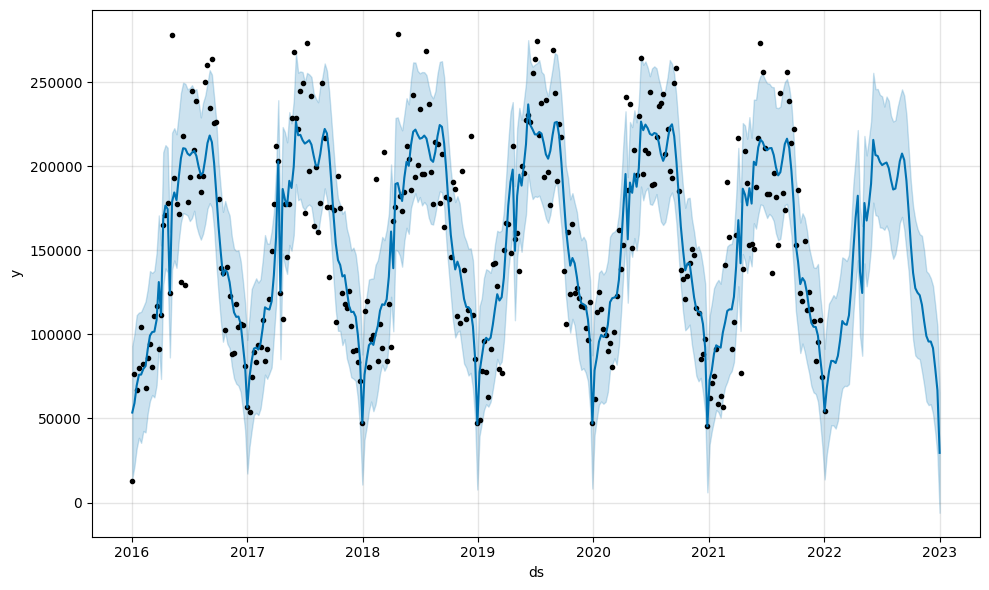

In [10]:
model_weekly = Prophet(holidays=holidays, changepoint_prior_scale=1, seasonality_prior_scale=0.1, scaling='absmax')
model_weekly.add_country_holidays(country_name='Germany')
#model_weekly.add_regressor('temp')
model_weekly.fit(df_bonn_weekly)
future_weekly = model_weekly.make_future_dataframe(periods=52, freq='W')

#future_weekly['temp'] = pd.concat([df_bonn_weekly['temp'], df_test_temp_weekly['Temperature (°C)']], ignore_index=True)

forecast_weekly = model_weekly.predict(future_weekly)
fig2 = model_weekly.plot(forecast_weekly)

<Figure size 1200x600 with 0 Axes>

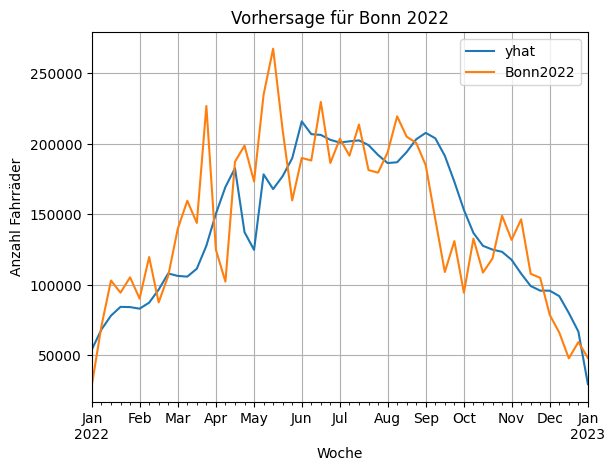

Mean Absolute Error (MAE): 27545.53
Root Mean Squared Error (RMSE): 36101.67
Median Absolute Percentage Error (MDAPE): 15.52


In [11]:
forecasted_values_weekly = forecast_weekly[['ds', 'yhat']].copy()
forecasted_values_weekly['ds'] = pd.to_datetime(forecasted_values_weekly['ds'])

measured_values_weekly = df_test_weekly[['Datetime', 'Bonn2022']].copy()
measured_values_weekly = measured_values_weekly.rename(columns={'Datetime': 'ds'})
measured_values_weekly['ds'] = pd.to_datetime(measured_values_weekly['ds'])

merged_data_weekly = pd.merge(forecasted_values_weekly, measured_values_weekly, on='ds', how='inner')
merged_data_weekly.set_index('ds', inplace=True)

plt.figure(figsize=(12,6))
merged_data_weekly.plot()
plt.title('Vorhersage für Bonn 2022')
plt.ylabel('Anzahl Fahrräder')
plt.xlabel('Woche')
plt.grid()
plt.show()

mae_weekly = mean_absolute_error(merged_data_weekly['Bonn2022'], merged_data_weekly['yhat'])
mse_weekly = mean_squared_error(merged_data_weekly['Bonn2022'], merged_data_weekly['yhat'])
mdape_weekly = median_absolute_percentage_error(merged_data_weekly['Bonn2022'], merged_data_weekly['yhat'])

print(f"Mean Absolute Error (MAE): {mae_weekly:.2f}")
print(f"Root Mean Squared Error (RMSE): {math.sqrt(mse_weekly):.2f}")
print(f"Median Absolute Percentage Error (MDAPE): {mdape_weekly:.2f}")

In [12]:
df_bonn_monthly = df_training_monthly[['Datetime', 'Bonn']]
df_bonn_monthly = df_bonn_monthly.rename(columns={'Datetime': 'ds', 'Bonn': 'y'})

df_temp_monthly = pd.read_csv('training_data_integrated.csv', index_col='Datetime', parse_dates=True)
df_temp_monthly = df_temp_monthly.resample('M').mean()
df_temp_monthly = df_temp_monthly.reset_index(drop=True)

df_bonn_monthly = pd.concat([df_bonn_monthly, df_temp_monthly['Temperature (°C)']], axis=1)
df_bonn_monthly = df_bonn_monthly.rename(columns={'Temperature (°C)': 'temp'})

df_bonn_monthly.to_csv('prophet_monthly_integrated.csv')

df_test_temp_monthly = df_test.resample('M').mean()

df_bonn_monthly['temp'] = np.where((df_bonn_monthly['temp'] < -10.0), np.nan, df_bonn_monthly['temp'])
df_bonn_monthly['temp'] = df_bonn_monthly['temp'].fillna(method='ffill')

In [13]:
df_bonn_monthly

,ds,y,temp
0,2016-01-31,340599.0,4.158871
1,2016-02-29,348947.0,4.477874
2,2016-03-31,423557.0,4.968952
3,2016-04-30,691519.0,9.137917
4,2016-05-31,882133.0,14.588844
...,...,...,...
67,2021-08-31,839741.0,16.956855
68,2021-09-30,973900.0,16.264028
69,2021-10-31,639206.0,11.145161
70,2021-11-30,487770.0,5.809028


19:59:00 - cmdstanpy - INFO - Chain [1] start processing
19:59:03 - cmdstanpy - INFO - Chain [1] done processing


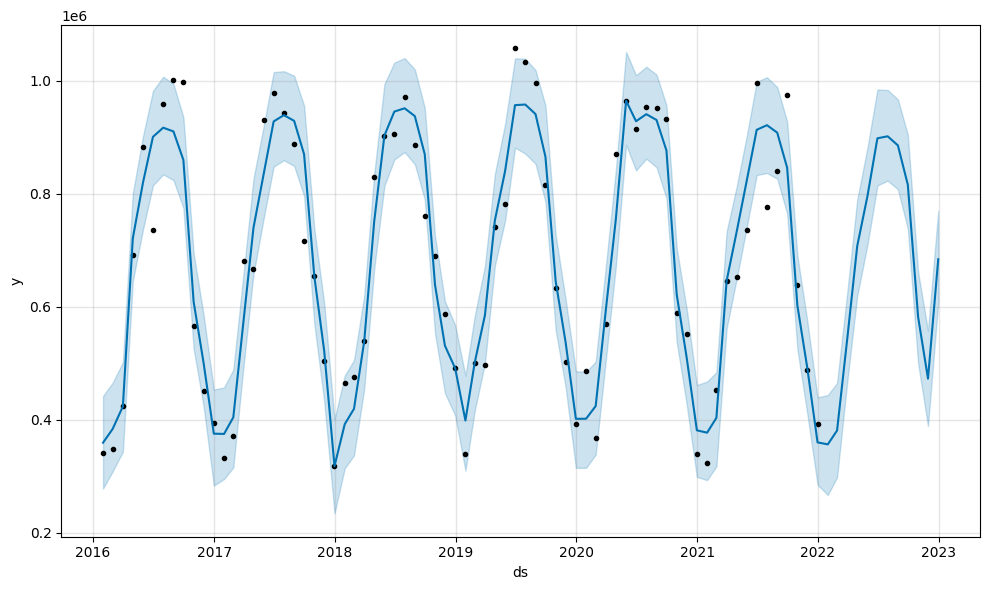

In [14]:
model_monthly = Prophet(holidays=holidays, changepoint_prior_scale=0.5, seasonality_prior_scale=0.1, scaling='absmax')
model_monthly.add_country_holidays(country_name='Germany')
#model_monthly.add_regressor('temp')
model_monthly.fit(df_bonn_monthly)
future_monthly = model_monthly.make_future_dataframe(periods=12, freq='M')

#future_monthly['temp'] = pd.concat([df_bonn_monthly['temp'], df_test_temp_monthly['Temperature (°C)']], ignore_index=True)

forecast_monthly = model_monthly.predict(future_monthly)
fig3 = model_monthly.plot(forecast_monthly)

<Figure size 1200x600 with 0 Axes>

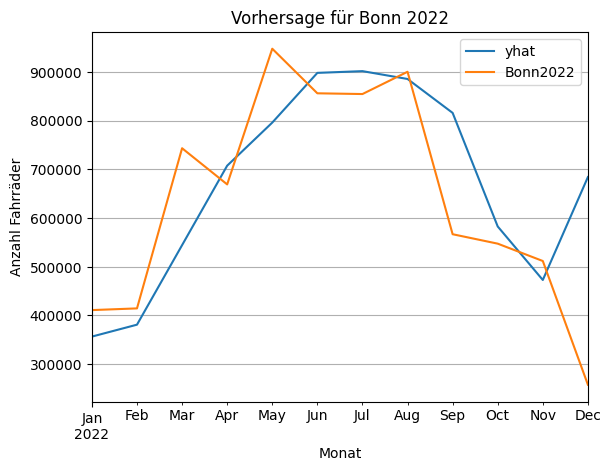

Mean Absolute Error (MAE): 110873.48
Root Mean Squared Error (RMSE): 163041.53
Median Absolute Percentage Error (MDAPE): 7.84


In [15]:
forecasted_values_monthly = forecast_monthly[['ds', 'yhat']].copy()
forecasted_values_monthly['ds'] = pd.to_datetime(forecasted_values_monthly['ds'])

measured_values_monthly = df_test_monthly[['Datetime', 'Bonn2022']].copy()
measured_values_monthly = measured_values_monthly.rename(columns={'Datetime': 'ds'})
measured_values_monthly['ds'] = pd.to_datetime(measured_values_monthly['ds'])

merged_data_monthly = pd.merge(forecasted_values_monthly, measured_values_monthly, on='ds', how='inner')
merged_data_monthly.set_index('ds', inplace=True)

plt.figure(figsize=(12,6))
merged_data_monthly.plot()
plt.title('Vorhersage für Bonn 2022')
plt.ylabel('Anzahl Fahrräder')
plt.xlabel('Monat')
plt.grid()
plt.show()

mae_monthly = mean_absolute_error(merged_data_monthly['Bonn2022'], merged_data_monthly['yhat'])
mse_monthly = mean_squared_error(merged_data_monthly['Bonn2022'], merged_data_monthly['yhat'])
mdape_monthly = median_absolute_percentage_error(merged_data_monthly['Bonn2022'], merged_data_monthly['yhat'])

print(f"Mean Absolute Error (MAE): {mae_monthly:.2f}")
print(f"Root Mean Squared Error (RMSE): {math.sqrt(mse_monthly):.2f}")
print(f"Median Absolute Percentage Error (MDAPE): {mdape_monthly:.2f}")

In [144]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon = '365 days')
df_cv

  0%|          | 0/5 [00:00<?, ?it/s]

13:53:13 - cmdstanpy - INFO - Chain [1] start processing
13:53:13 - cmdstanpy - INFO - Chain [1] done processing
13:53:14 - cmdstanpy - INFO - Chain [1] start processing
13:53:14 - cmdstanpy - INFO - Chain [1] done processing
13:53:15 - cmdstanpy - INFO - Chain [1] start processing
13:53:15 - cmdstanpy - INFO - Chain [1] done processing
13:53:16 - cmdstanpy - INFO - Chain [1] start processing
13:53:17 - cmdstanpy - INFO - Chain [1] done processing
13:53:18 - cmdstanpy - INFO - Chain [1] start processing
13:53:18 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-02,14580.988674,4764.372904,24575.988499,11325.0,2019-01-01
1,2019-01-03,12891.872144,3582.419669,23939.580275,10288.0,2019-01-01
2,2019-01-04,11350.908764,1325.320365,21053.799895,10040.0,2019-01-01
3,2019-01-05,8074.967414,-1901.524552,18213.516825,4716.0,2019-01-01
4,2019-01-06,9879.509129,193.666911,19666.093612,4287.0,2019-01-01
...,...,...,...,...,...,...
1820,2021-12-27,9377.703688,-294.599776,19058.602718,9729.0,2020-12-31
1821,2021-12-28,12835.333679,3796.629246,22151.496682,7595.0,2020-12-31
1822,2021-12-29,13226.941026,4009.393757,22847.717277,9772.0,2020-12-31
1823,2021-12-30,11383.313247,1844.970130,21085.670172,11774.0,2020-12-31


In [145]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 12:00:00,3.777307e+07,6145.980146,4692.287534,0.344804,0.191806,0.265396,0.917582
1,37 days 00:00:00,3.680140e+07,6066.415685,4617.908943,0.349116,0.190680,0.266559,0.923077
2,37 days 12:00:00,3.730884e+07,6108.096393,4670.664273,0.350533,0.190680,0.267595,0.923077
3,38 days 00:00:00,3.694287e+07,6078.064774,4644.718955,0.360950,0.190680,0.271008,0.928571
4,38 days 12:00:00,3.682119e+07,6068.046496,4622.708214,0.358050,0.189763,0.267663,0.928571
...,...,...,...,...,...,...,...,...
653,363 days 00:00:00,5.175536e+07,7194.119805,5411.072381,0.357012,0.209458,0.295600,0.868132
654,363 days 12:00:00,5.287034e+07,7271.199278,5493.055475,0.360250,0.218187,0.298015,0.862637
655,364 days 00:00:00,5.026847e+07,7090.025747,5383.812311,0.354747,0.218187,0.296116,0.868132
656,364 days 12:00:00,5.227818e+07,7230.365191,5516.367834,0.360780,0.223429,0.300484,0.857143


In [146]:
df_p.loc[df_p.idxmin()]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 12:00:00,3.777307e+07,6145.980146,4692.287534,0.344804,0.191806,0.265396,0.917582
17,45 days 00:00:00,3.389111e+07,5821.607368,4564.878834,0.379991,0.192981,0.277072,0.928571
17,45 days 00:00:00,3.389111e+07,5821.607368,4564.878834,0.379991,0.192981,0.277072,0.928571
17,45 days 00:00:00,3.389111e+07,5821.607368,4564.878834,0.379991,0.192981,0.277072,0.928571
460,266 days 12:00:00,6.498486e+07,8061.318869,6407.843073,0.308183,0.204754,0.268703,0.796703
589,331 days 00:00:00,5.862180e+07,7656.487563,5591.276289,0.322433,0.155447,0.255907,0.818681
640,356 days 12:00:00,5.468443e+07,7394.892259,5451.404513,0.316177,0.195157,0.254279,0.862637
175,124 days 00:00:00,9.379665e+07,9684.866865,7803.987532,0.510677,0.298983,0.364024,0.679487


In [176]:
import itertools

cutoffs = pd.to_datetime(['2019-01-01', '2020-01-01', '2020-12-31'])

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_bonn_monthly)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
print(all_params[np.argmin(rmses)])

14:39:21 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing
14:39:25 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] done processing
14:39:29 - cmdstanpy - INFO - Chain [1] start processing
14:39:29 - cmdstanpy - INFO - Chain [1] done processing
14:39:32 - cmdstanpy - INFO - Chain [1] start processing
14:39:32 - cmdstanpy - INFO - Chain [1] done processing
14:39:41 - cmdstanpy - INFO - Chain [1] start processing
14:39:41 - cmdstanpy - INFO - Chain [1] done processing
14:39:44 - cmdstanpy - INFO - Chain [1] start processing
14:39:44 - cmdstanpy - INFO - Chain [1] done processing
14:39:47 - cmdstanpy - INFO - Chain [1] start processing
14:39:47 - cmdstanpy - INFO - Chain [1] done processing
14:39:50 - cmdstanpy - INFO - Chain [1] start processing
14:39:50 - cmdstanpy - INFO - Chain [1] done processing
14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale           rmse
0                     0.001                     0.01  225424.705988
1                     0.001                     0.10   93881.182650
2                     0.001                     1.00   94807.128939
3                     0.001                    10.00  103913.381718
4                     0.010                     0.01  224281.491294
5                     0.010                     0.10   94446.459161
6                     0.010                     1.00   96244.821658
7                     0.010                    10.00  100169.474844
8                     0.100                     0.01  224936.364757
9                     0.100                     0.10   94319.981101
10                    0.100                     1.00   95276.547921
11                    0.100                    10.00   98618.127782
12                    0.500                     0.01  224796.136210
13                    0.500                     